**1.Importing and Loading Libraries**

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

**2.Load and Understand the Data**

In [64]:
df=pd.read_excel(r'C:\Users\ramak\Downloads\PE Analyst Assesment (1).xlsx')
df.head()
df.info()
df.dtypes
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Ticket ID                        65 non-null     object
 1   Ticket Subject                   65 non-null     object
 2   Agent                            65 non-null     object
 3   Group                            65 non-null     object
 4   Ticket Create Date Time          65 non-null     object
 5   Supplier ID                      65 non-null     object
 6   Ticket Resolved Date Time        65 non-null     object
 7   Ticket Assigned date             56 non-null     object
 8   Supplier voice/ Voice of Seller  65 non-null     object
 9   Resolution shared by agent       65 non-null     object
 10  Is taging Correct                65 non-null     object
 11  Issue Identification Correct     65 non-null     object
dtypes: object(12)
memory usage: 6.2+ KB


(65, 12)

**3.Assumptions and Data Cleaning**

Standardizing column names by removing extra spaces and converting them to lowercase for consistency. Converted datetime columns
from string datatype to datetime format, created separate columns for date and time for better understanding and readability.

In [65]:
# Standardizing column names
df.columns=df.columns.str.strip().str.lower().str.replace(" ",'_')

# My ticket_create_date,ticket_resolved_date, assigned_date columns showing object, converting it into date and time format
# Convert ticket create date
df['ticket_create_date_time']=pd.to_datetime(df['ticket_create_date_time'],errors='coerce')
# Convert ticket_resolve date ( DD/MM/YYYY format needs dayfirst=True)
df['ticket_resolved_date_time']=pd.to_datetime(df['ticket_resolved_date_time'],errors='coerce',dayfirst=True)
# Converting ticket_assign_date to( DD/MM/YYYY format)
df['ticket_assigned_date']=pd.to_datetime(df['ticket_assigned_date'],errors='coerce',dayfirst=True)

# checking NaNs
df.isnull().sum()

# creating new columns for create date and create time

# ticket create date
df['ticket_create_date']=df['ticket_create_date_time'].dt.date

# ticket create time
df['ticket_create_time']=df['ticket_create_date_time'].dt.time

# ticket resolved date
df['ticket_resolved_date']=df['ticket_resolved_date_time'].dt.date

# ticket resolve time
df['ticket_resolved_time']=df['ticket_resolved_date_time'].dt.time

# ticket assigned time
df['ticket_assigned_time']=df['ticket_assigned_date'].dt.time

# ticket assigned date
df['ticket_assigned_date']=df['ticket_assigned_date'].dt.date

**4. Logical Date Error**

One ticket was marked as resolved before it was created,indicating a timeline inconsistency.

In [66]:
# This is logically invalid, a ticket cannot be resolved before it was created. May be a manual or system data entry error.
date_issue=(df['ticket_create_date'] > df['ticket_resolved_date'])
df.loc[date_issue]

,ticket_id,ticket_subject,agent,group,ticket_create_date_time,supplier_id,ticket_resolved_date_time,ticket_assigned_date,supplier_voice/_voice_of_seller,resolution_shared_by_agent,is_taging_correct,issue_identification_correct,ticket_create_date,ticket_create_time,ticket_resolved_date,ticket_resolved_time,ticket_assigned_time
0,x1,I have not received my Return/RTO shipment,a1,OPS SS,2025-06-02 16:18:15,s1,2025-02-24 01:01:58,NaT,Return Not yet delivered,Order is in transit,No,Yes,2025-06-02,16:18:15,2025-02-24,01:01:58,NaT


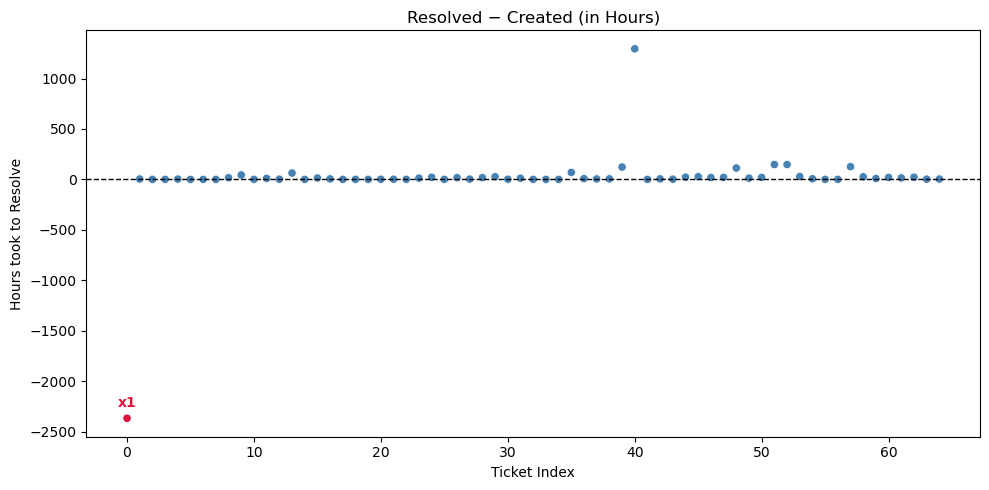

In [73]:
# Visualization showing how much time is taken in hours between ticket create and resolve time.(-ve value is shown for invalid ticket which is resolved before it is created)

df['delta_hours'] = (df['ticket_resolved_date_time'] - df['ticket_create_date_time']).dt.total_seconds() / 3600

# Prepare the plot layout
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(1, 1)

# logical date error graph
ax1 = fig.add_subplot(gs[0, 0])
sns.scatterplot(
    x=np.arange(len(df)),
    y=df["delta_hours"],
    hue=df["delta_hours"] < 0,  # logical error if negative
    palette={True: "crimson", False: "steelblue"},
    legend=False,
    ax=ax1,
)
ax1.set(
    title="Resolved − Created (in Hours)",
    xlabel="Ticket Index",
    ylabel="Hours took to Resolve",
)
ax1.axhline(0, color="black", ls="--", lw=1)

# Highlight Ticket ID x1 if it exists
if "x1" in df["ticket_id"].values:
    idx_x1 = df.index[df["ticket_id"] == "x1"][0]
    ax1.annotate(
        "x1",
        (idx_x1, df.loc[idx_x1, "delta_hours"]),
        textcoords="offset points",
        xytext=(0, 8),
        ha="center",
        color="crimson",
        weight="bold",
    )

plt.tight_layout()
plt.show()



**5.Date Format Inconsistencies**

The ticket date columns had inconsistent formats,for example, ticket_create_date_time had both YYYY-MM-DD and DD/MM/YYYY, while ticket_assigned_date included time with the date (HH:MM:SS DD-MM-YYYY) and had 9 missing values.These inconsistencies were identified and visualized using bar charts.

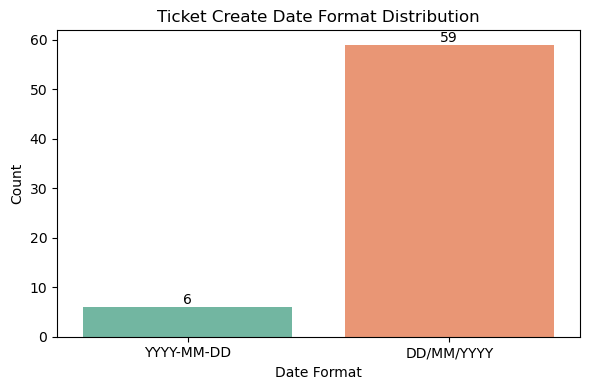

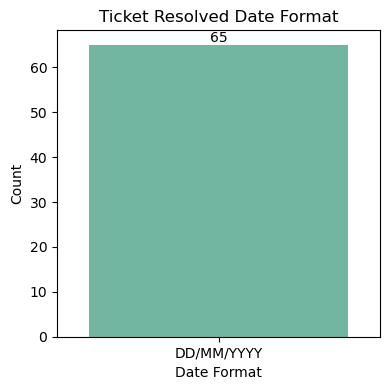

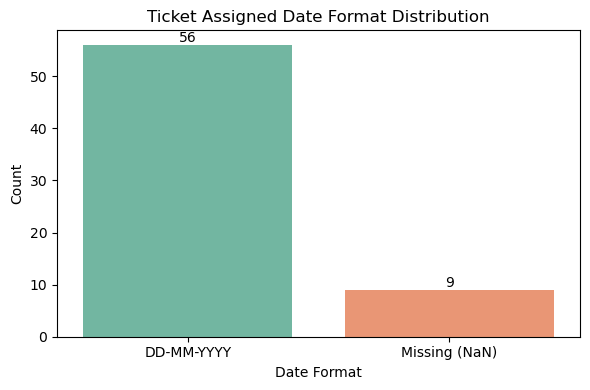

In [68]:
df_original=pd.read_excel(r'C:\Users\ramak\Downloads\PE Analyst Assesment (1).xlsx',dtype=str)
df_original.columns=df_original.columns.str.strip().str.lower().str.replace(" ",'_')

# Ticket Create Date Time: Mixed formats with 6 records using YYYY-MM-DD format and 59 using DD/MM/YYYY format.
year_month_date_format_create=df_original['ticket_create_date_time'].str.contains(r"\d{4}-\d{2}-\d{2}",na=False)
df_original.loc[year_month_date_format_create]

date_month_year_format_create=df_original['ticket_create_date_time'].str.contains(r"\d{2}/\d{2}/\d{4}",na=False)
df_original.loc[date_month_year_format_create]

# Ticket Resolved Date Time: All 65 records use DD/MM/YYYY format.
date_month_year_format_resolved=df_original['ticket_resolved_date_time'].str.contains(r"\d{2}/\d{2}/\d{4}",na=False)
df_original.loc[date_month_year_format_resolved]

# Ticket Assigned Date: 56 records use DD/MM/YYYY format, inconsistent with other date fields.
df_original['ticket_assigned_date'] = df_original['ticket_assigned_date'].astype(str)
date_month_year_format_assigned=df_original['ticket_assigned_date'].str.contains(r"\d{2}:\d{2}:\d{2} \d{2}-\d{2}-\d{4}", 
na=False)
df_original.loc[date_month_year_format_assigned]



# graph for Ticket Create Date

create_format_counts = {
    "YYYY-MM-DD": year_month_date_format_create.sum(),
    "DD/MM/YYYY": date_month_year_format_create.sum()
}

# Create bar plot
plt.figure(figsize=(6, 4))
bars = sns.barplot(x=list(create_format_counts.keys()), y=list(create_format_counts.values()), palette="Set2")
plt.title("Ticket Create Date Format Distribution")
plt.xlabel("Date Format")
plt.ylabel("Count")

# Add values on top of bars
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{int(bar.get_height())}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


# graph for Ticket Resolved Format

# Format count
resolved_format_counts = {
    "DD/MM/YYYY": date_month_year_format_resolved.sum()
}

# Plot
plt.figure(figsize=(4, 4))
bars = sns.barplot(x=list(resolved_format_counts.keys()), y=list(resolved_format_counts.values()), palette="Set2")
plt.title("Ticket Resolved Date Format")
plt.xlabel("Date Format")
plt.ylabel("Count")

# Add count label
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{int(bar.get_height())}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

# graph for Ticket Assigned Date
assigned_format_counts = {
    "DD-MM-YYYY": date_month_year_format_assigned.sum(),
    "Missing (NaN)": (df_original['ticket_assigned_date'].str.lower() == "nan").sum()
}
plt.figure(figsize=(6, 4))
bars = sns.barplot(x=list(assigned_format_counts.keys()), y=list(assigned_format_counts.values()), palette="Set2")
plt.title("Ticket Assigned Date Format Distribution")
plt.xlabel("Date Format")
plt.ylabel("Count")

# Adding value labels
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{int(bar.get_height())}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()


**6.Workflow Logic Violations**

9 tickets out of 65 were found with no assign date, which means they were likely not assigned to any agent.this may lead to
delays in resolution and should be addressed in the process.

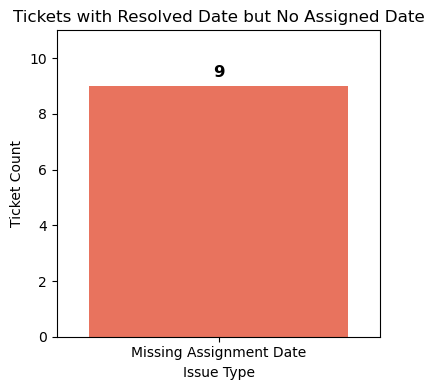

In [43]:
# 9 tickets have resolution dates but no assignment dates.
df[df['ticket_assigned_date'].isna()]

# Creating bar plot
count_missing_assigned = df['ticket_assigned_date'].isna().sum()
plt.figure(figsize=(4, 4))
sns.barplot(x=["Missing Assignment Date"], y=[count_missing_assigned], color="tomato")

# Title and axis labels
plt.title("Tickets with Resolved Date but No Assigned Date")
plt.ylabel("Ticket Count")
plt.xlabel("Issue Type")

# Adding the count label on top
plt.text(0, count_missing_assigned + 0.2, str(count_missing_assigned), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, count_missing_assigned + 2)  # Add some space above the bar
plt.tight_layout()
plt.show()

**7.Tagging vs. Issue Identification Conflicts**

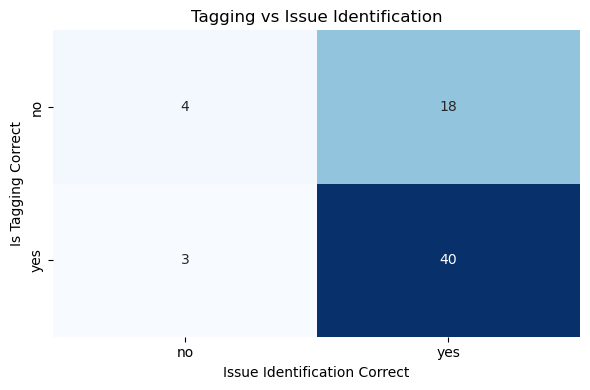

In [74]:
# 21 rows show inconsistency between the agent’s tagging and the correctness of issue identification.(Either the tagging is incorrect or identification is not correct)

# Filter rows where tagging correctness ≠ issue identification correctness
conflict_df = df[
    df['is_taging_correct'].str.strip().str.lower() !=
    df['issue_identification_correct'].str.strip().str.lower()
][['ticket_id', 'is_taging_correct', 'issue_identification_correct']]

# Reset index for a clean table
conflict_df.reset_index(drop=True, inplace=True)
conflict_df

# making graph using heatmap
df['is_taging_correct_clean'] = df['is_taging_correct'].str.strip().str.lower()
df['issue_identification_correct_clean'] = df['issue_identification_correct'].str.strip().str.lower()

# creating confusion matrix
conf_mat = pd.crosstab(df['is_taging_correct_clean'], df['issue_identification_correct_clean'])

# plotting the graph
fig, ax = plt.subplots(figsize=(6, 4))  # Create figure and axes
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
ax.set_title("Tagging vs Issue Identification")
ax.set_xlabel("Issue Identification Correct")
ax.set_ylabel("Is Tagging Correct")
plt.tight_layout()
plt.show()



**8.Terminology Inconsistencies**

The ticket_subject column had inconsistent entries like "Other issue", "Other Issue", and "Others" that refer to the same category but were treated as separate values due to capitalization and wording.These were identified using value_counts and visualized with a bar chart to highlight the inconsistency.

In [70]:
# Ticket Subjects: "Other issue" vs "Other Issue" vs "Others" (inconsistent values).
ticket_subject_duplicates=['Other issue','Other Issue','Others']
filt_subject=df['ticket_subject'].isin(ticket_subject_duplicates)
df.loc[filt_subject]['ticket_subject'].value_counts()

Other issue    41
Others         16
Other Issue     1
Name: ticket_subject, dtype: int64

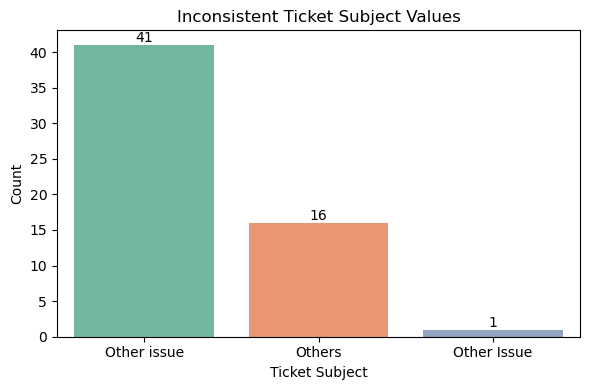

In [71]:
# count and storing the values
subject_counts = df.loc[filt_subject, 'ticket_subject'].value_counts()

# plotting graph
plt.figure(figsize=(6, 4))
bars = sns.barplot(x=subject_counts.index, y=subject_counts.values, palette="Set2")
plt.title("Inconsistent Ticket Subject Values")
plt.xlabel("Ticket Subject")
plt.ylabel("Count")

# Add labels on top of bars
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{int(bar.get_height())}",
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()